In [1]:
import torch.nn as nn
import json, os, sys, math, random, re, time
from collections import Counter, defaultdict
import numpy as np
import torch
import torch.nn.functional as F
from torch.optim import Adam
from typing import List, Dict, Any, Tuple
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm, trange
from matplotlib import pyplot as plt

In [2]:
class MLP(nn.Module):
    def __init__(self,
                 hidden_dim_multipliers: List[float],
                 dim: int,
    ):
        super().__init__()
        
        hidden_dims = [dim * m for m in hidden_dim_multipliers]
        self.dim = dim
        layers = nn.ModuleList()

        layer_sizes = [self.dim] + hidden_dims + [self.dim]
        for dim_in, dim_out in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(nn.Linear(dim_in, dim_out)) # default bias=True?
            layers.append(nn.ReLU())
        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return x 

In [3]:
# create data
class dataset(Dataset):
    def __init__(self,
                 size: int,
                 dim: int, 
                 output_regions: List[Tuple[int]], # List of disjoint intervals
                 ):

        super().__init__()

        self.data = []
        self.dim = dim
        # probability of each interval
        self.probs = [(r[1] - r[0]) for r in output_regions]
        for i in range(size):
            # choose interval
            interval_idx = random.choices(range(len(output_regions)), weights=self.probs)[0]
            y = random.uniform(*output_regions[interval_idx])
            x = 1 / y
            self.data.append((
                torch.tensor([x]*self.dim), 
                torch.tensor([y]*self.dim)
            ))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        return self.data[i]

In [4]:
def train(model, dataloader, optim, criterion, device, disable_tqdm=False):
    model.train()
    epoch_loss = 0
    #print("model dtype = ", next(model.parameters()).dtype)
    for (x, y) in tqdm(dataloader, desc="Training", mininterval=10, disable=disable_tqdm):
        
        optim.zero_grad()
        
        output = model(x.to(device))
        loss = criterion(output, y.to(device))
        
        loss.backward()
        optim.step()

        epoch_loss += loss.item()
        
    return epoch_loss/len(dataloader)

def val(model, dataloader, criterion, device, return_output=False, disable_tqdm=False):
    model.eval()
    epoch_loss = 0
    model_output = []
    with torch.no_grad():
        for (x, y) in tqdm(dataloader, desc="Validating", mininterval=10, disable=disable_tqdm):
            
            output = model(x.to(device)) 
            loss = criterion(output, y.to(device))

            epoch_loss += loss.item()
            if return_output:
                model_output.append(output.detach().cpu())
    return epoch_loss/len(dataloader), model_output


In [5]:
config = {
    "hidden_dim_multipliers": [1024],
    "dim": 1,
    'data_size_tr': 10000,
    "output_regions_tr": [(20, 30), (50, 80)],
    'heldout_ratio': 0.1,
    'lr': 0.0001,
    'batch_size': 16,
    'epochs': 100,
    "output_regions_ood": [(1, 5), (15, 20)],
    "data_size_ood": 1000,
    "eval_batch_size": 64,
}

In [6]:
Data = dataset(config['data_size_tr'], config['dim'], config['output_regions_tr'])

num = len(Data)
train_num, heldout_num = num-int(num*config['heldout_ratio']), int(num*config['heldout_ratio'])
train_data, heldout_data = random_split(
    Data,
    [train_num, heldout_num]
)
val_num, test_num = heldout_num-int(heldout_num*0.5), int(heldout_num*0.5)
val_data, test_data = random_split(
    heldout_data,
    [val_num, test_num]
)

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(val_data)}')
print(f'Number of testing examples: {len(test_data)}')

train_dl = DataLoader(train_data, shuffle=True, batch_size=config['batch_size'])
val_dl = DataLoader(val_data, shuffle=True, batch_size=config['batch_size'])
test_dl = DataLoader(test_data, shuffle=True, batch_size=config['batch_size'])


Number of training examples: 9000
Number of validation examples: 500
Number of testing examples: 500


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP(
    hidden_dim_multipliers = config['hidden_dim_multipliers'], 
    dim = config['dim']
).to(device)

optim = Adam(model.parameters(), lr = float(config['lr']), weight_decay=1e-5)
criterion = nn.MSELoss().to(device)

print("Trainable Params: {}".format(sum([p.numel() for p in model.parameters() if p.requires_grad])))
print("Prepare Model: finish\n")

/home/yingshac/workspace/llms_do_math/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Trainable Params: 3073
Prepare Model: finish



In [8]:
best_val_loss = float('inf')
best_val_acc = 0.0

train_loss_curve, val_loss_curve = [], []
pgbar = trange(config['epochs'])
pgbar.set_description(f'Train Loss:  inf   Val. Loss:  inf ')
for epc in pgbar:

    train_loss = train(model, train_dl, optim, criterion, device, disable_tqdm=True)
    val_loss, _ = val(model, val_dl, criterion, device, disable_tqdm=True)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        #torch.save(model.state_dict(), os.path.join(config["save_dir"], config["date"], "model.pt"))
    train_loss_curve.append(train_loss)
    val_loss_curve.append(val_loss)
    
    pgbar.set_description(f'Train Loss: {train_loss:.3f}  Val. Loss: {val_loss:.3f}')
    
#print("Training: finish\n")
test_loss, _ = val(model, test_dl, criterion, device, disable_tqdm=True)
print(f'Test Loss: {test_loss:.3f}')


Train Loss: 21.290  Val. Loss: 19.645: 100%|██████████| 100/100 [01:27<00:00,  1.15it/s]  

Test Loss: 20.772


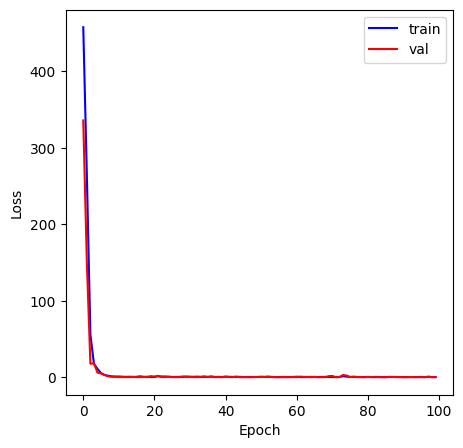

In [14]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.plot(train_loss_curve, c='b', label='train')
ax.plot(val_loss_curve, c='r', label='val')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.legend()
plt.show()

In [15]:
X, Y, model_outputs = [], [], []
for s in trange(1, 101):
    output_region = [[s, s+1]]
    oodData = dataset(config['data_size_ood'], config['dim'], output_region)
    ood_dl = DataLoader(oodData, shuffle=True, batch_size=config['eval_batch_size'])

    test_loss, model_output = val(model, ood_dl, criterion, device, True, True)
    X.append(s+0.5)
    Y.append(test_loss)
    model_outputs.append(torch.cat(model_output, dim=0).mean().item())


100%|██████████| 100/100 [00:03<00:00, 26.13it/s]


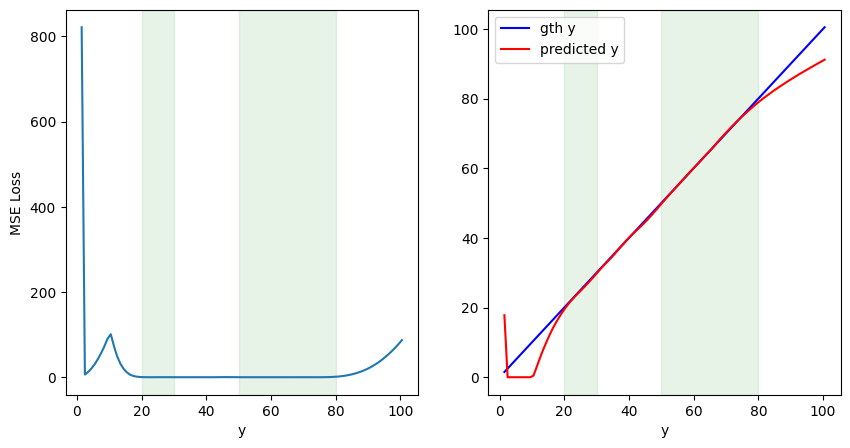

In [12]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
ax.plot(X, Y)
ax.set_xlabel('y')
ax.set_ylabel('MSE Loss')
for s, e in config['output_regions_tr']: ax.axvspan(s, e, alpha=0.1, color='forestgreen')
ax = fig.add_subplot(122)
ax.plot(X, X, c='b', label='gth y')
ax.plot(X, model_outputs, c='r', label='predicted y')
ax.set_xlabel('y')
for s, e in config['output_regions_tr']: ax.axvspan(s, e, alpha=0.1, color='forestgreen')
ax.legend()
plt.show()

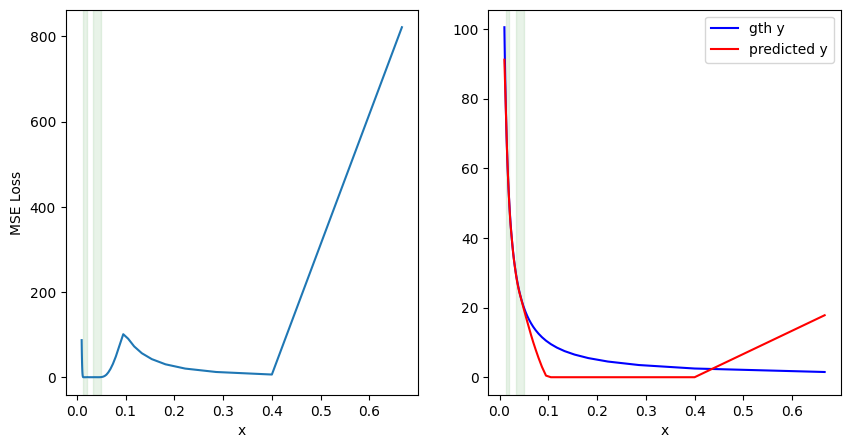

In [13]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
ax.plot([1/y for y in X], Y)
ax.set_xlabel('x')
ax.set_ylabel('MSE Loss')
for s, e in config['output_regions_tr']: ax.axvspan(1/e, 1/s, alpha=0.1, color='forestgreen')
ax = fig.add_subplot(122)
ax.plot([1/y for y in X], X, c='b', label='gth y')
ax.plot([1/y for y in X], model_outputs, c='r', label='predicted y')
ax.set_xlabel('x')
for s, e in config['output_regions_tr']: ax.axvspan(1/e, 1/s, alpha=0.1, color='forestgreen')
ax.legend()
plt.show()